# The Quantum Fourier Transform

This is a very important quantum transform that does the following to an orthonormal basis, $\{|0\rangle\, |1\rangle\, \ldots, |N-1\rangle\}$:
$$|j\rangle \rightarrow \frac{1}{\sqrt{N}}\sum\limits_{k=0}^{N-1}e^{i\frac{2\pi k}{N}j} |k\rangle$$

We consider the special case for $N=2^n$. The circuit design is made easier for a general state written in binary as $|j_nj_{n-1}\ldots j_1\rangle$ if we write the transform as:
$$|j_nj_{n-1}\ldots j_1\rangle \rightarrow \left(\frac{|0\rangle + e^{i2\pi\cdot(0.j_1)} |1\rangle}{\sqrt 2}\right)\otimes\left(\frac{|0\rangle + e^{i2\pi\cdot(0.j_{2}j_{1})} |1\rangle}{\sqrt 2}\right)\otimes\ldots\otimes\left(\frac{|0\rangle + e^{i2\pi\cdot(0.j_{n}j_{n-1}\ldots j_1)} |1\rangle}{\sqrt 2}\right)$$

Which is equivalent to:

$$|j\rangle\rightarrow \bigotimes\limits_{k = n-1}^{0} \left(\frac{|0\rangle + e^{i\frac{2\pi 2^k}{N}j} |1\rangle}{\sqrt 2}\right) \equiv \bigotimes\limits_{k = n-1}^{0} R_z\left(\frac{2\pi 2^k}{N}j\right)|+\rangle$$

In [1]:
from qiskit import QuantumCircuit, assemble, Aer
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_vector, array_to_latex, plot_bloch_multivector
from math import sqrt, pi
from IPython.display import display, Math
from qiskit.quantum_info import random_statevector
svsim = Aer.get_backend('aer_simulator') 

In [2]:
def init(qc, n, state):
    i = n - 1
    while state > 0:
        if state % 2 == 1:
            qc.x(n - 1 - i)
        i -= 1
        state = state // 2
def QFT(qc, n):
    for i in range(n - 1, -1, -1):
        qc.barrier()
        qc.h(i)
        for j in range(2, 2 + i):
            qc.cp(2*np.pi/(2**j), (i - (j - 1)), i)

def reverse(qc, n):
    for i in range(0, n//2):
        qc.swap(i, n - 1 - i)

def inv_QFT(qc, n):
    for i in range(n):
        qc.barrier()
        for j in range(1 + i, 1, -1):
            qc.cp(-2*np.pi/(2**j), (i - (j - 1)), i)
        qc.h(i)

# The Analysis
Based on the description:
$$|j\rangle\rightarrow \bigotimes\limits_{k = n-1}^{0} \left(\frac{|0\rangle + e^{i\frac{2\pi 2^k}{N}j} |1\rangle}{\sqrt 2}\right) \equiv \bigotimes\limits_{k = n-1}^{0} R_z\left(\frac{2\pi 2^k}{N}j\right)|+\rangle$$
We can understand the transform as encoding the frequencies $\left(\dfrac{2\pi}{2^n}2^{n-1}, \dfrac{2\pi}{2^n}2^{n-2}, \ldots, \dfrac{2\pi}{2^n}2^{1}, \dfrac{2\pi}{2^n}2^{0} \right)$ in the qubits of the circuit. <br>
Given a state $|j\rangle$, QFT returns the $|+\rangle\equiv(1, 0, 0)$ state of each of the $n$ qubits rotated by $j$ times the corresponding frequency about the $z$-axis of the Bloch sphere.<br>

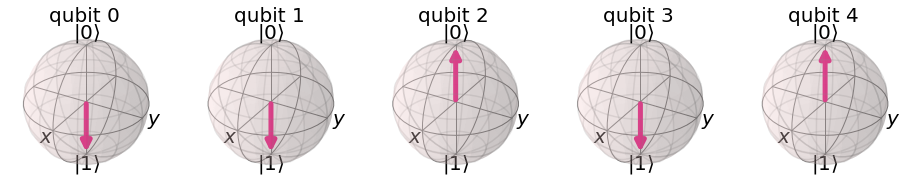

In [3]:
n = 5
state = 11
qc = QuantumCircuit(n)
init(qc, n, state)
qc_init = qc.copy()
qc_init.save_statevector()
statevector = svsim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

As can be seen below, the $k\in\{0, 1, 2, 3, 4\}$ th qubit after the QFT is rotated from $(1, 0, 0)$ by $\frac{2\pi}{2^n}2^{k}j = \frac{11\pi}{16} \cdot2^k$<br>

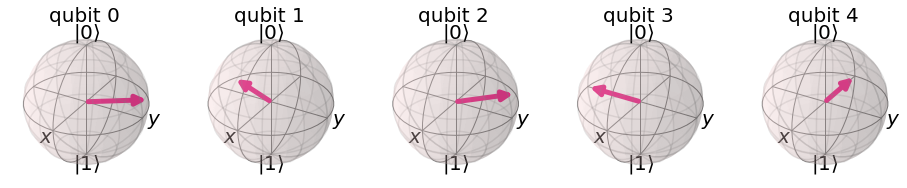

In [4]:
QFT(qc, n)
qc.barrier()
reverse(qc, n)
qc.save_statevector()
statevector = svsim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

# The Inverse Transform
For a sequence of unitary gates, 
$$U = U_1U_2\ldots U_n\quad U^{-1} = U^{\dagger}_n\ldots U^{\dagger}_2U^{\dagger}_1$$

We use this to get the circuit for the inverse QFT. To confirm that it is indeed the inverse, we can run both and check to see if the final and the initial states match.

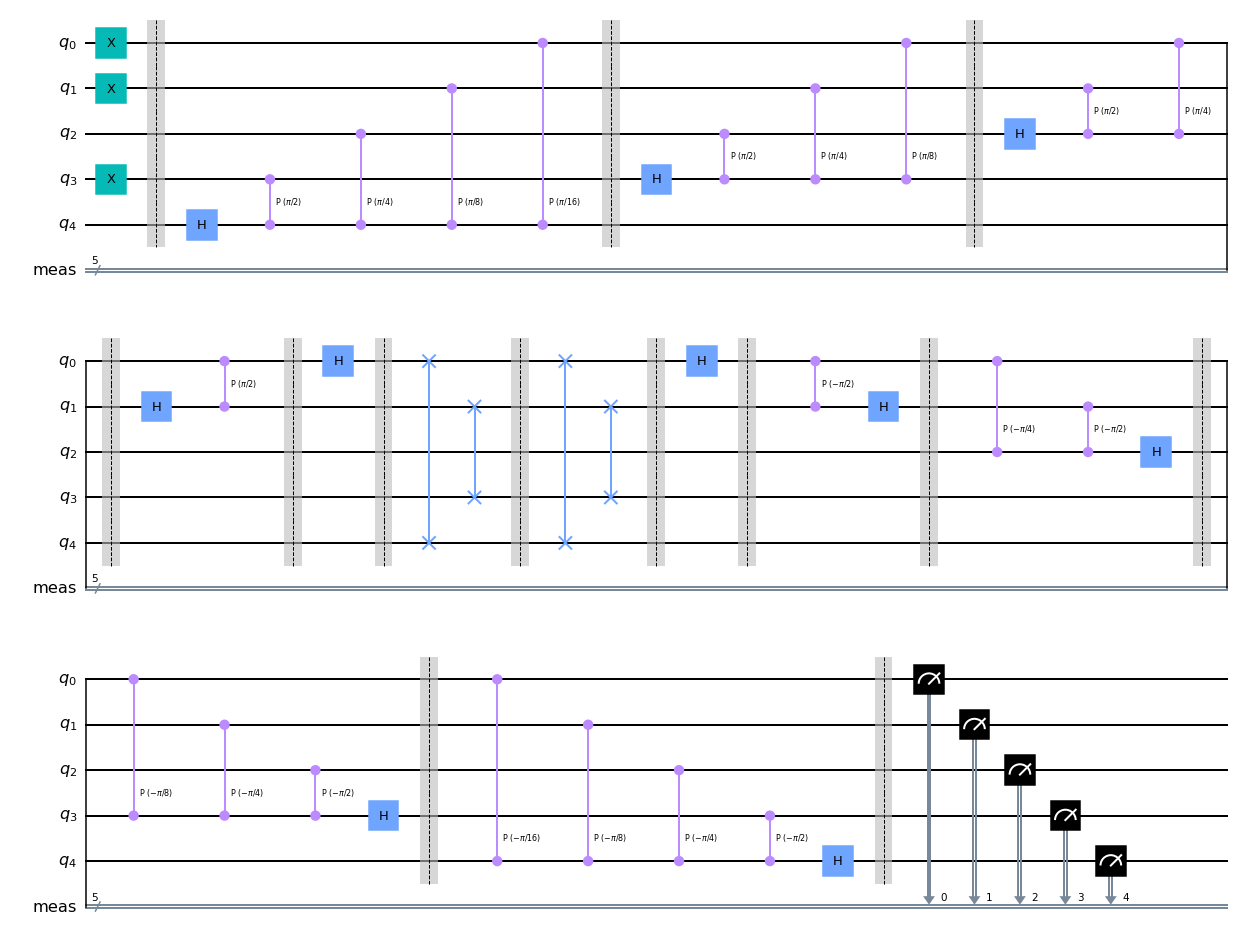

In [5]:
reverse(qc, n)
inv_QFT(qc, n)
cbits = [i for i in range(n)]
qc.measure_all()
qc.draw('mpl')

The circuit does indeed return the initial state $|11\rangle$, as seen below.

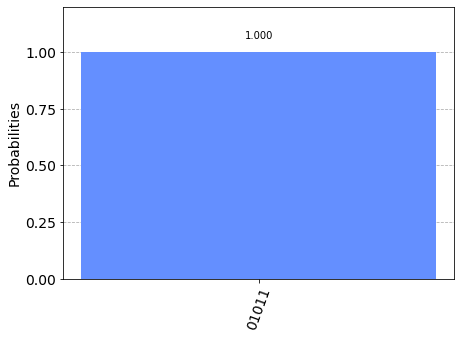

In [6]:
counts = svsim.run(assemble(qc)).result().get_counts()
plot_histogram(counts)